$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

*Drew Boston*

## Overview

Here is my code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  I have included various test cases throughout the notebook, as well as two major applications of these methods; one regression problem and one classification problem. 

## Required Code

For this notebook to work, it requires the following files:

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) (provided by Professor Anderson) and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

I've grouped the various imports necessary here.

In [308]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn
import mlutils as ml
import time
import sys
import copy


**checkAccuracy(A,B):**

While I could use properties of neuralnetworks (specifically error trace) to eliminate this function, I already had it written and prefer to use my own implementations when possible! :)

So, this function will return the percentage of incorrect classifications based on A and B provided to it, where A is the predicted values, and B is the actual (i.e. target) values.

In [33]:
#note: calculates percentage of incorrect classifications, NOT correct classifications. I believe this is correct - double check results!
def checkAccuracy(A, B):
    count = 0
    num = len(B)
    for i in range(num):
        if A[i] != B[i]:
            count += 1
    return (count/num)
    

**trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):**

This function follows the general outline provided to us in the assignment page. I have commented throughout to further explain what occurs at each major step.

In [107]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    
    #results will be a list of [hiddenLayer, trainPerformance, testPerformance, time], one per each hiddenLayer
    results = []
    
    ##need to check for classification problem and adjust accordingly !
    
    for hiddenLayer in hiddenLayerStructures:
        trainPerformance = []  #training errors
        testPerformance = []  #testing errors
        times = []  #training times
        startTime = time.time()
        for i in range(numberRepetitions):
            #Xtrain is training data, results of which are contrasted to Ttrain
            #Xtest is testing data, results of which are contrasted against Ttest
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T, (trainFraction, (1-trainFraction)), classification=classify)
            #now we check for classification vs. non-classification:
            
            if classify:
                nnet = nn.NeuralNetworkClassifier(X.shape[1], hiddenLayer, len(np.unique(T)))
                nnet.train(Xtrain, Ttrain, nIterations = numberIterations)
                #now net is created / trained, need to check accuracy of predictions now (Ctrain/Ctest)
                Ctrain = nnet.use(Xtrain)
                Ctest = nnet.use(Xtest)
                trainAcc = checkAccuracy(Ctrain, Ttrain)
                testAcc = checkAccuracy(Ctest, Ttest)
            
            #if not classify, then:
            #note; could combine a lot of this if-else statement, but keeping it this way for easier reading.
            #shouldn't affect runtimes hardly at all (nanoseconds)
           
            else:
                nInputs = Xtrain.shape[1]
                nOutputs = Ttrain.shape[1]   #following from notebook 16 In[19]
                nnet = nn.NeuralNetwork(nInputs, hiddenLayer, nOutputs)
                nnet.train(Xtrain, Ttrain, nIterations = numberIterations)
                #now net is created / trained, need to check accuracy of predictions now (Ctrain/Ctest)
                Ctrain = nnet.use(Xtrain)
                Ctest = nnet.use(Xtest)
                #using root mean square error, check accuracy of nnet predictions:
                trainAcc = np.sqrt(np.mean((Ctrain-Ttrain)**2))
                testAcc = np.sqrt(np.mean((Ctest-Ttest)**2))
            
            #append train and test accuracy to appropriate lists
            trainPerformance.append(trainAcc)
            testPerformance.append(testAcc)
        
        #finished all training / accuracy testing for this hiddenLayer, so stop time
        endTime = time.time()
        #add to results:
        results.append([hiddenLayer, trainPerformance, testPerformance, endTime-startTime])
    return results
            
            

**summarize(results):**

This function replaces individual errors (i.e. training performances; there will be one per repetition) by the mean of all errors.

In [108]:
def summarize(results):
    summary = []
    
    #note: result (below) will have form:
    #[hiddenLayer, trainPerformance, testPerformance, time]
    for result in results:
        meanTrain = np.mean(np.array(result[1]))
        meanTest = np.mean(np.array(result[2]))
        #keep hiddenLayer and time the same, but change middle entries to mean values
        summary.append([result[0], meanTrain, meanTest, result[3]])
    return summary  

**bestNetwork(summary):**

This function takes the output from `summarize(results)` (not directly; must be called with the output) and returns the network with the minimum error for a particular hidden layer structure.

In [109]:
def bestNetwork(summary):
    #note: concerned only with minimum testing error, not training !!
    minTest = float("inf")
    bestNet = []
    #iterate through summary "nets" checking for one with smallest meanTest value
    for net in summary:
        if net[2] < minTest:
            minTest = net[2]
            bestNet = net
    return bestNet
    

**plotErrorTrace(net):**

This function simply plots the error trace for a given net.

In [212]:
def plotErrorTrace(net):
    errors = nnet.getErrorTrace()
    plt.figure()
    plt.plot(range(len(errors)), nnet.getErrorTrace());

## Basic Test Cases


In [112]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))

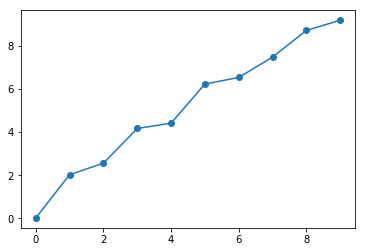

In [113]:
plt.plot(X, T, 'o-');

In [114]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.71, 0.56, 0.56, 0.56, 0.42, 0.25, 0.18, 0.17, 0.14, 0.13, 0.13,
       0.11, 0.11, 0.1 , 0.1 , 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
       0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07])

In [115]:
nnet = nn.NeuralNetwork(X.shape[1], [5, 5, 5], T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.71, 0.44, 0.44, 0.44, 0.44, 0.32, 0.23, 0.16, 0.16, 0.15, 0.15,
       0.14, 0.13, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.11,
       0.11, 0.1 , 0.1 , 0.09, 0.09, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,
       0.07, 0.07])

In [116]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.2600930080204022,
   0.2708703169497367,
   0.290256639218149,
   0.26494943118506736,
   0.25617610132524266],
  [0.44570690245569056,
   0.41728854924665615,
   0.7827907392246528,
   0.5067874463997968,
   0.5360852163607206],
  0.12441706657409668],
 [10,
  [0.18207658658042258,
   0.21826777782154058,
   0.23902874332506058,
   0.15930895471877815,
   0.2489541508946792],
  [1.4049760587128015,
   0.73537459326619,
   0.5671713173380161,
   0.7649484266870509,
   0.5374637853531044],
  0.12390589714050293],
 [[10, 10],
  [0.2695845763876307,
   0.2967996301673941,
   0.22412446908744144,
   0.30709837218899305,
   0.23373574650946982],
  [1.1538528616674848,
   0.3823228075330273,
   0.9772685408497342,
   0.21566350847745058,
   0.5499562643279273],
  0.15434694290161133]]

In [117]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [118]:
summarize(results)

[[0, 0.37129627750300437, 0.4182415706111351, 0.0325469970703125],
 [1, 0.30289917029890384, 0.4596955060389428, 1.0706202983856201],
 [2, 0.25708451473456573, 0.579985149219548, 1.0632262229919434],
 [10, 0.24790845394411284, 0.6194735555039638, 1.108302116394043],
 [[10, 10], 0.24400093433641132, 0.6035269065959988, 1.5978379249572754],
 [[5, 5, 5, 5], 0.2516219570242854, 0.6577436826001124, 2.021970748901367],
 [[2, 2, 2, 2, 2], 0.29416365327315985, 0.5154064183081671, 2.030289888381958]]

In [119]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.37129627750300437, 0.4182415706111351, 0.0325469970703125]
Hidden Layers 0 Average RMSE Training 0.37 Testing 0.42 Took 0.03 seconds


We are seeing the expected results here, so I will move on to the regression experiment!

## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv



I used wget (commented out below to prevent multiple downloads when re-running notebook) to download the file. 

In [125]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

--2018-11-05 16:36:04--  http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [text/csv]
Saving to: 'energydata_complete.csv.1'

energydata_complete 100%[===================>]  11.42M  3.58MB/s    in 3.3s    

2018-11-05 16:36:07 (3.44 MB/s) - 'energydata_complete.csv.1' saved [11979363/11979363]



Because of the piazza post [here](https://piazza.com/class/jl2i7paafyf49w?cid=236) (where Professor Anderson commented), I believe it is best/acceptable to use Pandas to read the csv file. I found it a lot easier, anyway! Especially as I have experience with dataFrames from CS435 (Big Data).

Per the assignment instructions, I ignored the first column of each row which contains a data and time, as well as the last two columns of random variables. They will not be used in our modeling of this data. 

In [152]:
import pandas

In [169]:
data = pandas.read_csv('energydata_complete.csv')

As you can see, pandas (or, really, the dataframe structure) formats the data quite nicely into a much more readable format.

In [170]:
data

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
5,2016-01-11 17:50:00,50,40,19.890000,46.026667,19.200000,44.500000,19.790000,44.933333,18.890000,...,17.000000,45.290000,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.500000,19.790000,44.900000,18.890000,...,17.000000,45.290000,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763
7,2016-01-11 18:10:00,60,50,19.856667,45.560000,19.200000,44.500000,19.730000,44.900000,18.890000,...,17.000000,45.290000,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890
8,2016-01-11 18:20:00,60,40,19.790000,45.597500,19.200000,44.433333,19.730000,44.790000,18.890000,...,17.000000,45.290000,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702
9,2016-01-11 18:30:00,70,40,19.856667,46.090000,19.230000,44.400000,19.790000,44.863333,18.890000,...,17.000000,45.290000,5.950000,734.300000,91.500000,5.500000,40.000000,4.650000,3.089314,3.089314


Here we delete the columns mentioned above, as they are not pertinent to our data.

In [172]:
del data['date']
del data['rv1']
del data['rv2']

In [173]:
data.shape

(19735, 26)

In [191]:
data.iloc[:2,:]

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.7900,19.79,44.73,19.0,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.7225,19.79,44.79,19.0,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2


Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So

In [192]:
XenergyDF = data.iloc[:,2:]
TenergyDF = data.iloc[:,:2]

In [193]:
XenergyDF.shape, TenergyDF.shape

((19735, 24), (19735, 2))

Xnames and Tnames are not used in the network training process, but I created them anyway to verify I had the correct dataframe as opposed to the examples provided in the assignment page.

In [194]:
Xnames = list(XenergyDF)
Xnames

['T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint']

In [195]:
Tnames = list(TenergyDF)
Tnames

['Appliances', 'lights']

Obviously, I need to convert from a dataframe to an np array before I can train on the data, as my trainNNs function was not set up to allow dataframes.

In [198]:
Xenergy = XenergyDF.values
Tenergy = TenergyDF.values

In [202]:
Xenergy.shape, Tenergy.shape

((19735, 24), (19735, 2))

Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  100 may not be enough.  If for your larger networks the error is still decreasing after 100 iterations you should train all nets for more than 100 iterations.

Now use your `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.

In [203]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, [5, 5], [10, 10]], 10, 100)

In [204]:
summarize(results)

[[0, 67.31728265768666, 66.55628176339283, 2.478935718536377],
 [5, 65.16452768754593, 67.25218560774262, 18.975735902786255],
 [[5, 5], 64.88541083880764, 65.53609762149055, 27.974726915359497],
 [[10, 10], 62.84204920607955, 63.894966915599056, 51.639703035354614]]

In [206]:
bestNetwork(summarize(results))

[[10, 10], 62.84204920607955, 63.894966915599056, 51.639703035354614]

Here you can see the error trace drops significantly in the first 30-40 repetitions; I believe 100 will work fine here (but I'll know for sure after the next test with 10 different hidden layers).

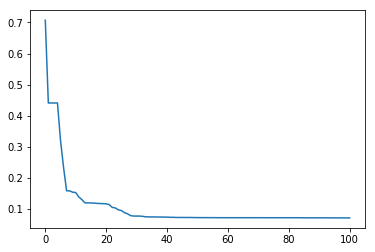

In [213]:
plotErrorTrace(nnet)

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

Here is my test with 10 different hidden layer structures. I tried to very the dimensions to get a better idea of an ideal structure.

In [386]:
hiddenLayersList = []

hiddenLayersList.append(5)
hiddenLayersList.append([5,5])
hiddenLayersList.append([5,5,5])
hiddenLayersList.append([10,10])
hiddenLayersList.append([10,10,10])
hiddenLayersList.append([15,15])
hiddenLayersList.append([15,15,15])
hiddenLayersList.append([20,20])
hiddenLayersList.append([20,20,20])
hiddenLayersList.append([25,25])
hiddenLayersList.append([25,25,25])


In [387]:
results = trainNNs(Xenergy, Tenergy, 0.8, hiddenLayersList, 10, 100)

Here are the results of the different hidden layer structures:

In [388]:
summarize(results)

[[5, 65.18252971617815, 65.72369596641478, 20.339557886123657],
 [[5, 5], 64.63605805889063, 65.15944183454671, 30.576945781707764],
 [[5, 5, 5], 64.90793787357026, 65.67863288254398, 33.8553740978241],
 [[10, 10], 62.695095389297805, 65.12622602035802, 46.38473987579346],
 [[10, 10, 10], 63.0052796084846, 64.90807971453897, 61.18878698348999],
 [[15, 15], 61.85718721898822, 65.20432064698508, 62.21410608291626],
 [[15, 15, 15], 61.703355250260095, 63.893132761463505, 91.23616099357605],
 [[20, 20], 61.57873689197182, 62.98635144039122, 85.9911961555481],
 [[20, 20, 20], 61.52487942696166, 63.76296080244227, 117.22685217857361],
 [[25, 25], 61.26607394479547, 64.25327089893088, 104.66477179527283],
 [[25, 25, 25], 61.73815915659937, 63.00424011936084, 153.9306800365448]]

In [389]:
bestNetwork(summarize(results))

[[20, 20], 61.57873689197182, 62.98635144039122, 85.9911961555481]

Checking the error trace is still ok with 100 iterations for the last net trained (with hidden layer = [25,25,25]):

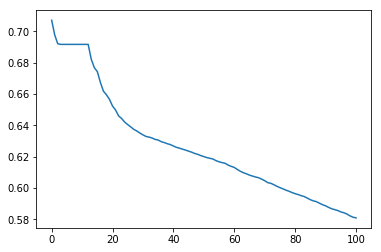

In [390]:
plotErrorTrace(nnet)

Definitely far from ideal, so I'm going to re-run the tests using 400 iterations instead.

In [ ]:
results = trainNNs(Xenergy, Tenergy, 0.8, hiddenLayersList, 10, 400)

So, the three best hidden layer structures throughout our testing are (in order from top = best to bottom):

* `[20, 20], 61.57873689197182, 62.98635144039122, 85.9911961555481]`
* `[25, 25, 25], 61.73815915659937, 63.00424011936084, 153.9306800365448]`
* `[20, 20, 20], 61.52487942696166, 63.76296080244227, 117.22685217857361]`

However, we had the overall minimum error using hidden layer structure [20,20], so that is what I will use going on to the next part.

In [395]:
startTime = time.time()
Xtrain, Ttrain, Xtest, Ttest = ml.partition(Xenergy, Tenergy, (0.8, 0.2), classification=False)
nnet = nn.NeuralNetwork(Xenergy.shape[1], [20,20], Tenergy.shape[1])
#changed numberIterations to 1000 here
nnet.train(Xtrain, Ttrain, 1000)
Ctrain = nnet.use(Xtrain)
Ctest = nnet.use(Xtest)
trainAcc = np.sqrt(np.mean((Ctrain-Ttrain)**2))
testAcc = np.sqrt(np.mean((Ctest-Ttest)**2))
endTime = time.time()

Checking the error trace one more time:

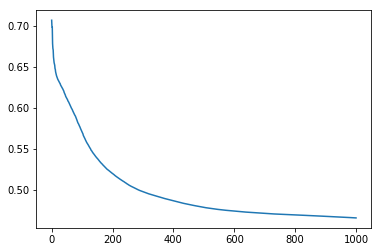

In [396]:
plotErrorTrace(nnet)

This looks good! So on to the plots:

**Appliances (predicted vs. actual):**

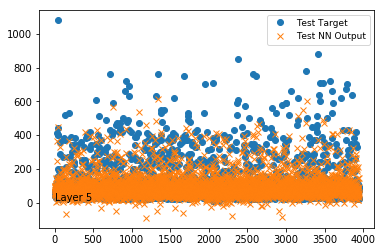

In [397]:
plt.subplot(1,1,1)
#using [:,:1] for appliance data
plt.plot(Ttest[:,:1], 'o', Ctest[:,:1],'x')
plt.text(8,12, 'Layer {}'.format(5))
plt.legend(('Test Target','Test NN Output'),loc='upper right',
            prop={'size':9});

**Lights (predicted vs. actual):**

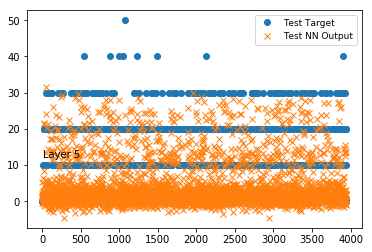

In [398]:
plt.subplot(1,1,1)
#using [:,1:] for lights data
plt.plot(Ttest[:,1:], 'o', Ctest[:,1:],'x')
plt.text(8,12, 'Layer {}'.format(5))
plt.legend(('Test Target','Test NN Output'),loc='upper right',
            prop={'size':9});

As you can see, there is a pretty wide spread of predictions for this data. I believe this is due to a wide, sporadic variety in appliance energy usage (as seen by the orange 'x's in the graphs above), making it difficult to approximate using a neural network. However, it does seem to have done relatively well; I imagine it could do even better with further fine-tuning. Interestingly, there are no predictions matching actual values values on the very high end of the y-axis'; I imagine this is because there are far fewer values utilizing this much energy, meaning the net was more likely to "skew" towards the more concentrated energy-efficient (lower) values.

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
     !unzip Anuran*zip
     
Read the data in the file `Frogs_MFCCs.csv` into python.  This will be a little tricky. Each line of the file is a sample of audio features plus three columns that label the sample by family, genus, and species. We will try to predict the species.  The tricky part is that the species is given as text.  We need to convert this to a target class, as an integer. The `numpy` function `unique` will come in handy here.

In [280]:
#!wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'

--2018-11-05 18:56:48--  http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip
Resolving archive.ics.uci.edu... 128.195.10.249
Connecting to archive.ics.uci.edu|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1300058 (1.2M) [application/zip]
Saving to: 'Anuran Calls (MFCCs).zip'

Anuran Calls (MFCCs 100%[===================>]   1.24M  1.41MB/s    in 0.9s    

2018-11-05 18:56:49 (1.41 MB/s) - 'Anuran Calls (MFCCs).zip' saved [1300058/1300058]



In [356]:
data = pandas.read_csv('Frogs_MFCCs.csv')

In [357]:
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [358]:
data.shape

(7195, 26)

In [359]:
#everything except last three columns
XanuranDF = data.iloc[:,:22]

In [360]:
XanuranDF.shape

(7195, 22)

In [361]:
XanuranDF.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [362]:
TanuranDF = data['Species']

This creates a dictionary where the key is the class name, and the value is its integer representation, starting from 0! (Required for classification; we cannot train the nets without converting "Species" to integer representations instead of strings)

In [363]:
classNames = np.unique(TanuranDF)
classNameDict = {}
for i in range(len(classNames)):
    classNameDict[classNames[i]] = i

Now, using classNameDict, we can create a new version of TanuranKey with integer values representing species, instead of strings:

In [364]:
#Note; without converting back, Tanuran will only have integers representing species (not strings)
#the actual name could be found by matching the integer value to the key (species name) in classNameDict
Tanuran = TanuranDF.copy()
for i in range(len(TanuranDF)):
    #does this work or do I need a temp dataFrame?
    Tanuran.loc[i] = classNameDict[TanuranDF.loc[i]]

In [365]:
Tanuran.head()

0    0
1    0
2    0
3    0
4    0
Name: Species, dtype: int64

In [366]:
Tanuran=Tanuran.values.reshape(7195,1)

In [367]:
Tanuran.shape

(7195, 1)

In [368]:
type(Tanuran)

numpy.ndarray

In [369]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


Everything looks good so far, just need to convert Xanuran to an np array (from dataFrame):

In [370]:
Xanuran = XanuranDF.values

In [371]:
type(Xanuran)

numpy.ndarray

Looks good! Let's proceed with the classification net training:

In [379]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=True)

In [380]:
summarize(results)

[[0, 0.03214037526059764, 0.03613620569840167, 2.3888731002807617],
 [5, 0.035892981236970115, 0.046421125781792916, 5.103965997695923],
 [[5, 5], 0.04635163307852676, 0.05726198749131341, 6.140919923782349]]

In [381]:
bestNetwork(summarize(results))

[0, 0.03214037526059764, 0.03613620569840167, 2.3888731002807617]

This matches what I expected per the results given in the assignment page. So, I'll proceed with the same process of testing multiple hidden layer structures to find an optimal one after checking our error trace goes to 0 in 100 repetitions:

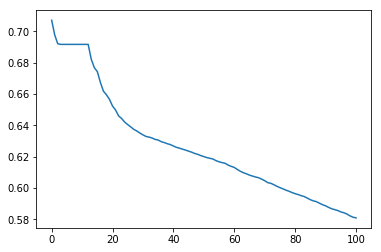

In [382]:
plotErrorTrace(nnet)

It does go to zero, but not with enough room to spare I feel comfortable. So, I'll up the repetitions to 500 (sorry, Mac [my laptop]), and re-check after it has finished.

In [400]:
hiddenLayersList = []

hiddenLayersList.append(5)
hiddenLayersList.append([5,5])
hiddenLayersList.append([5,5,5])
hiddenLayersList.append([10,10])
hiddenLayersList.append([10,10,10])
hiddenLayersList.append([15,15])
hiddenLayersList.append([15,15,15])
hiddenLayersList.append([20,20])
hiddenLayersList.append([20,20,20])
hiddenLayersList.append([25,25])
hiddenLayersList.append([25,25,25])

In [ ]:
results = trainNNs(Xanuran, Tanuran, 0.8, hiddenLayersList, 5, 500, classify=True)

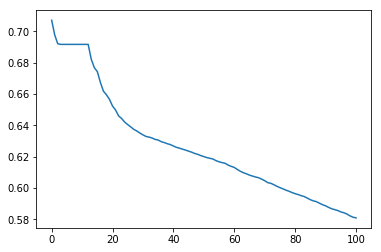

In [385]:
plotErrorTrace(nnet)

In [ ]:
summarize(results)

In [ ]:
bestNetwork(summarize(results))

## Grading

Download [A5grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A5grader.tar) and extract `A5grader.py` from it.

In [72]:
%run -i "A5grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Boston-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3000000000000003, 0.5], [[2, 2, 2], 4.3, 6.3999999999999995, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

A5 Execution Grade

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/68135).

## Extra Credit

  2. Repeat the above regression and classification experiments with a second regression data set and a second classification data set.
  
  2. Since you are collecting the performance of all repetitions for each network structure, you can calculate a confidence interval about the mean, to help judge significant differences. Do this for either the regression or the classification data and plot the mean test performance with confidence intervals for each network structure tested.  Discuss the statistical significance of the differences among the means.  One website I found to help with this is the site [Correct way to obtain confidence interval with scipy](https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy).
  
